### 1. ライブラリ・関数の読み込み

In [1]:
library(cmfrec)
library(Matrix)
library(MatrixExtra)
library(recommenderlab)
library(cmfrec)
library(ggplot2)
library(reshape2)
library(viridis)
library(gridExtra)
source("cmf.R")


'MatrixExtra' modifies important behaviors from 'Matrix'. See ?MatrixExtra-options.

Loading required package: arules


Attaching package: 'arules'


The following objects are masked from 'package:base':

    abbreviate, write


Loading required package: proxy


Attaching package: 'proxy'


The following object is masked from 'package:Matrix':

    as.matrix


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy

Loading required package: viridisLite



### 2. データの読み込み

In [2]:
brvehins <- load_bravehins(cas_dataset_path = "/Users/nanakato/projects/CASdatasets/data")
brvehins <- brvehins[grepl("Honda", brvehins$VehModel), ]
claim_types <- c("ClaimAmountRob", "ClaimAmountPartColl", "ClaimAmountTotColl", "ClaimAmountFire", "ClaimAmountOther")
brvehins[, "ClaimTotal"] <- rowSums(brvehins[, claim_types])
str(brvehins)


'data.frame':	81115 obs. of  24 variables:
 $ Gender             : Factor w/ 3 levels "Corporate","Female",..: 1 2 3 2 3 1 3 2 3 2 ...
 $ DrivAge            : Factor w/ 5 levels ">55","18-25",..: NA 4 4 3 1 NA 5 5 4 5 ...
 $ VehYear            : int  2006 2006 2007 2011 1995 2009 2004 2006 2010 2005 ...
 $ VehModel           : Factor w/ 4259 levels "Acura - Legend 3.2/3.5",..: 1754 1752 1728 1794 1799 1787 1775 1783 1780 1765 ...
 $ VehGroup           : Factor w/ 436 levels "Acura","Agrale - Marrua",..: 216 216 215 214 215 213 212 213 212 212 ...
 $ Area               : Factor w/ 40 levels "Acre","Alagoas",..: 40 13 19 30 30 24 4 24 30 20 ...
 $ State              : Factor w/ 27 levels "Acre","Alagoas",..: 25 25 16 25 25 13 4 13 25 25 ...
 $ StateAb            : Factor w/ 27 levels "AC","AL","AM",..: 26 26 18 26 26 11 3 11 26 26 ...
 $ ExposTotal         : num  1.51 0.5 0.5 0.1 0.5 ...
 $ ExposFireRob       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ PremTotal          : num  981.8 227.3 501.2 9

### 3. データの下処理

In [3]:
# category_to_analyze <- c("Gender", "DrivAge")
# category_to_analyze <- c("VehGroup", "VehYear")
category_to_analyze <- c("VehModel", "Area")

# 型だけに注目するよりもセル自体に注目した方が良いと思った
premium_total <- get_total(brvehins, category_to_analyze, "PremTotal", 0)
exposure_total <- get_total(brvehins, category_to_analyze, "ExposTotal", 0)
claim_total <- get_total(brvehins, category_to_analyze, "ClaimTotal")

# 純率にするか損害率にするかは要相談
pure_premium <- premium_total / exposure_total
loss_ratio <- claim_total / premium_total

# write.csv(pure_premium, "pure_premium.csv")
# write.csv(loss_ratio, "loss_ratio.csv")


aggregate_col: PremTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ExposTotal   group_cols: VehModelArea



[1] 125  40


aggregate_col: ClaimTotal   group_cols: VehModelArea



[1] 125  40


### 4. ハイパーパラメータの最適化

In [4]:
options(warn = -1)
best_params <- optimize_params(
  X = pure_premium, n_folds = 4, k_values = c(2, 5, 10, 15, 20), lambda_values = c(0.01, 0.1, 1, 10)
)


[1] "k: 2 lambda: 0.01 CV RMSE: 1177.84569391953"
[1] "k: 2 lambda: 0.1 CV RMSE: 950.102806712025"
[1] "k: 2 lambda: 1 CV RMSE: 880.721291008181"
[1] "k: 2 lambda: 10 CV RMSE: 793.218766197424"
[1] "k: 5 lambda: 0.01 CV RMSE: 5250.88994887521"
[1] "k: 5 lambda: 0.1 CV RMSE: 1447.44034779821"
[1] "k: 5 lambda: 1 CV RMSE: 907.888042097762"
[1] "k: 5 lambda: 10 CV RMSE: 862.5796555927"
[1] "k: 10 lambda: 0.01 CV RMSE: 2243.23394308825"
[1] "k: 10 lambda: 0.1 CV RMSE: 1317.42979107814"
[1] "k: 10 lambda: 1 CV RMSE: 1135.49848924594"
[1] "k: 10 lambda: 10 CV RMSE: 970.582948406198"
[1] "k: 15 lambda: 0.01 CV RMSE: 3027.34532325166"
[1] "k: 15 lambda: 0.1 CV RMSE: 1625.29839326582"
[1] "k: 15 lambda: 1 CV RMSE: 1162.4331527009"
[1] "k: 15 lambda: 10 CV RMSE: 809.34684143775"
[1] "k: 20 lambda: 0.01 CV RMSE: 1925.57364099281"
[1] "k: 20 lambda: 0.1 CV RMSE: 2049.81219868795"
[1] "k: 20 lambda: 1 CV RMSE: 1159.99491855323"
[1] "k: 20 lambda: 10 CV RMSE: 741.183630001375"


### 5. 予測精度の検証

In [5]:
split <- train_test_split(pure_premium)

cmf_args <- list(X = split$X_train, k = best_params$k, lambda = best_params$lambda, niter = 30, nonneg = TRUE, verbose = FALSE)
model <- do.call(CMF, cmf_args)

pred <- get_prediction(model, split$X_test)
calc_rmse(pred, split$X_test)


RMSE : 738.0091


[1] 738.0091

### 6. 予測結果の可視化

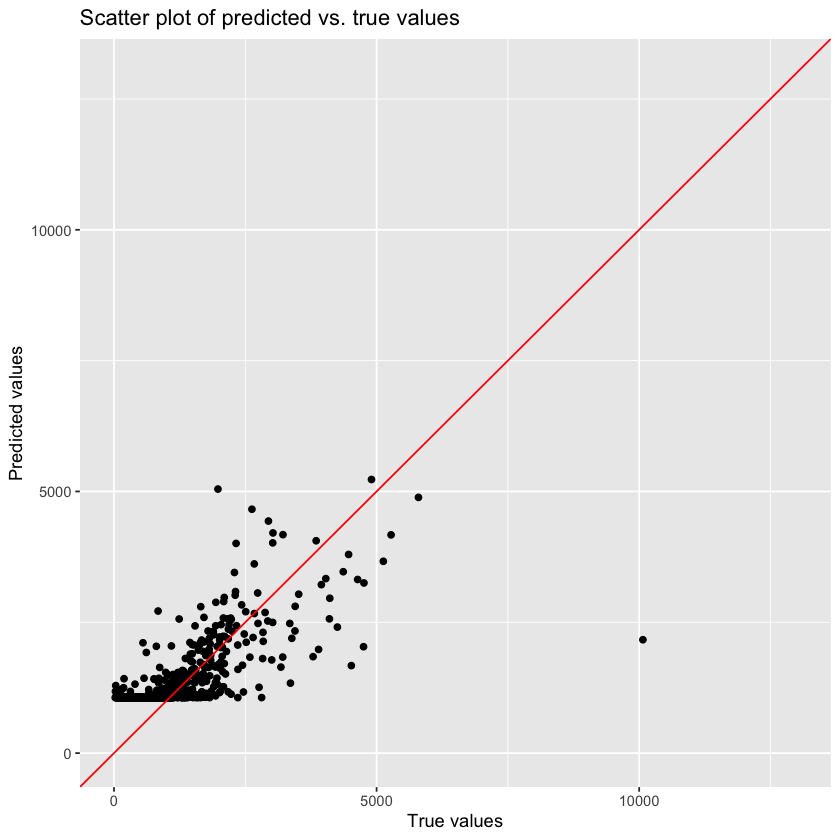

In [6]:
# テストデータにおける予測値と実測値の散布図

df <- data.frame(as.vector(split$X_test), as.vector(pred))
df <- na.omit(df)
colnames(df) <- c("actual", "prediction")
p <- ggplot(df, aes(x = actual, y = prediction)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    xlim(0, 13000) +
    ylim(0, 13000) +
    labs(title = "Scatter plot of predicted vs. true values", x = "True values", y = "Predicted values")
p


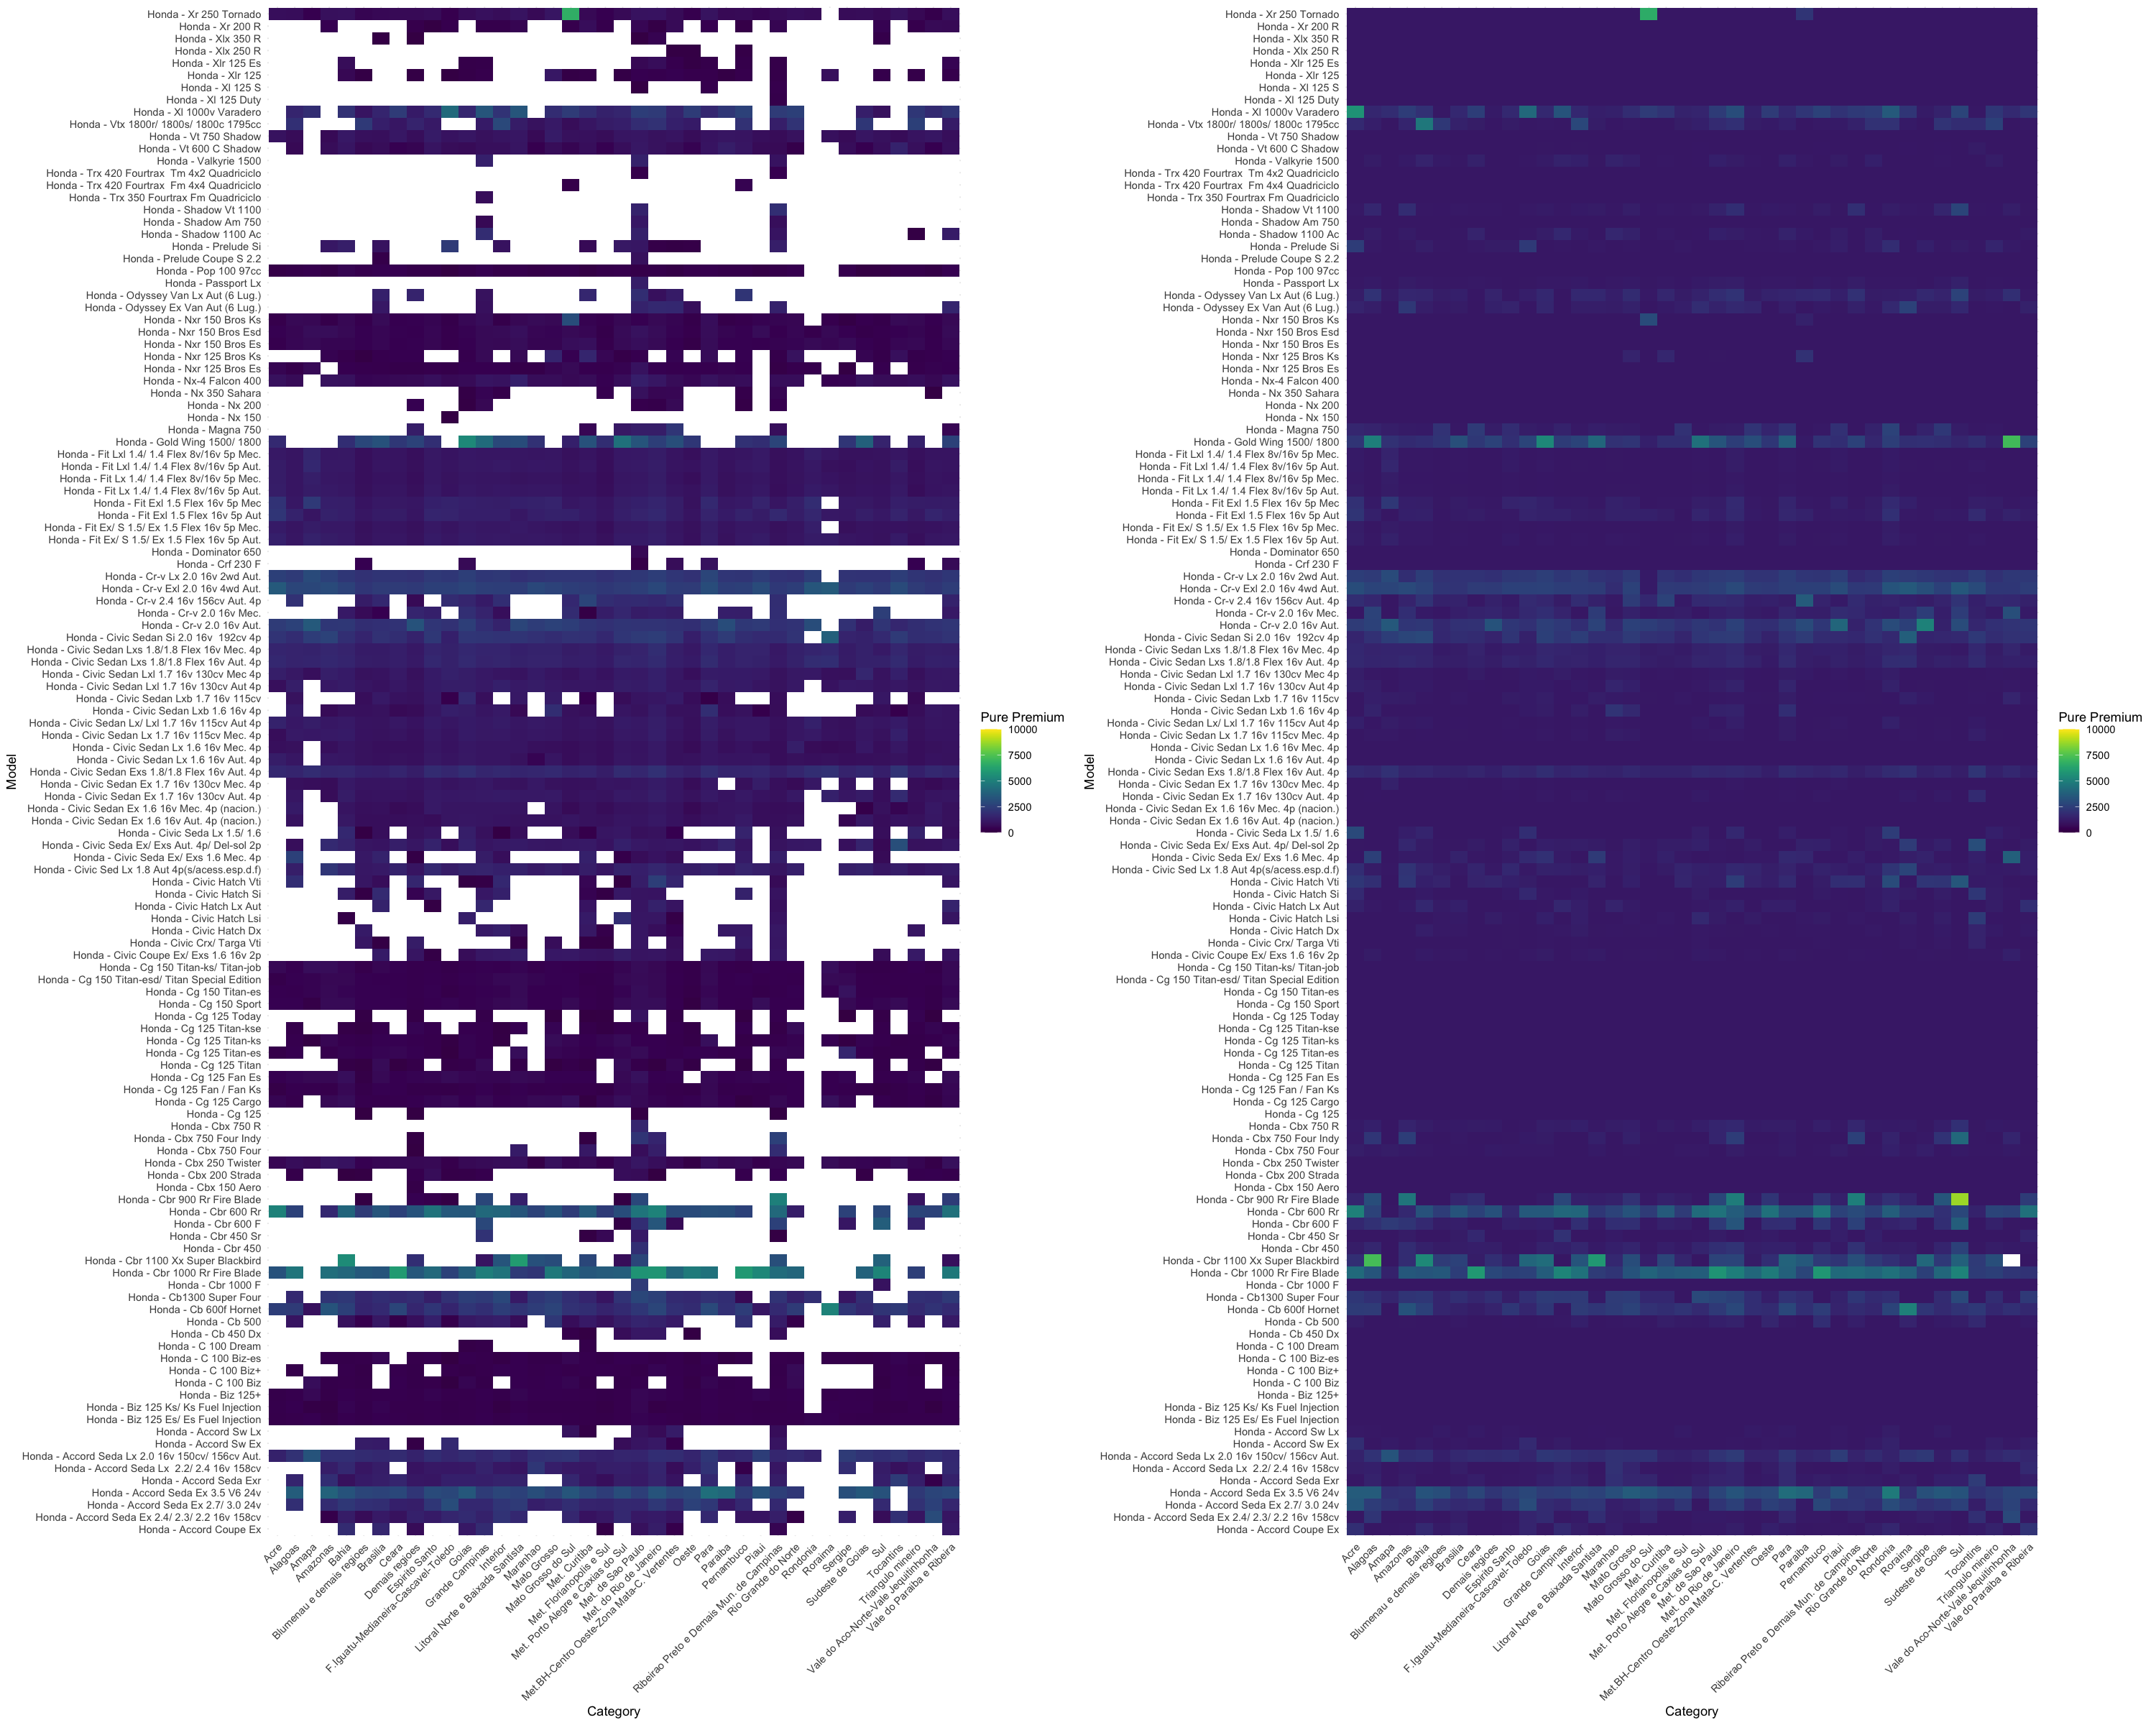

In [7]:
options(repr.plot.width = 25, repr.plot.height = 20)

# 全区分に対するヒートマップ（実績）
p1 <- visualize_heatmap(pure_premium)

# 全区分に対するヒートマップ（欠測を含む推定値）
actual <- pure_premium
actual[is.na(actual)] <- 0
estimated <- get_prediction(model, actual)
p2 <- visualize_heatmap(estimated)

grid.arrange(p1, p2, ncol = 2)
